Driver Distraction Classification



Driver Distraction Monitoring
This notebook is for the classification of driver behavior. We will do image pre-processing and use Deep learning CNN for identifying the behavior of the driver. Which is necessary for handling the unexpected road accident.

Nowadays vehicles are increasing exponentially. We need to be extra careful about the road incident. As there are a couple of things around you, which can distract the driving. We can use this model and implement a smart system, which will monitor driver activities at the time of driving and can alert him about the activities. It will reduce the number of roads accidents and will increase road safety.

State Farm Distracted Driver Detection has divided driving behavior into 10 classes. CLASS Description

C0 Safe Driving

C1 Texting - Right

C2 Talking On The Phone - Right

C3 Texting- left

C4 Talking on the Phone- left

C5 Operating The Radio

C6 Drinking

C7 Reaching Behind

C8 Hair And Makeup

C9 Talking To Passenger

We will implement a deep learning model, which will predict the driver activities at the time of driving.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import gc
import glob
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.activations import elu, softmax
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import BatchNormalization, Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [0]:
kaggleDir = '/content/drive/Shared drives/Tensors/DL/'
train_img_dir = 'drivers/train/'
test_img_dir = 'drivers/test/'
CLASSES = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
           "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
           "c8": "hair and makeup", "c9": " talking to passenger"}
IMG_DIM = 299
CHANNEL_SIZE = 3
SEED_VAL = 41
BATCH_SIZE = 50
EPOCHS = 20  # Tootal Number of epoch


In [0]:
img_rows = 224
img_cols = 224

In [0]:
tf.set_random_seed(SEED_VAL)
gc.enable()
np.random.seed(SEED_VAL)
random.seed(SEED_VAL)

In [0]:


df_train = pd.read_csv(kaggleDir + 'driver_imgs_list.csv', low_memory=True)
print('Number of Samples in trainset : {}'.format(df_train.shape[0]))
print('Number Of districted Classes : {}'.format(len((df_train.classname).unique())))

df_train = shuffle(df_train)



Number of Samples in trainset : 22424
Number Of districted Classes : 10


In [0]:
print("[INFO] : Load all the images.....")
trainImgDir = os.path.join(kaggleDir, train_img_dir)
testImgDir = os.path.join(kaggleDir, test_img_dir)
trainImgs = glob.glob(trainImgDir + '*/*.jpg')
testImgs = glob.glob(testImgDir + '*.jpg')
len(trainImgs), len(testImgs)

[INFO] : Load all the images.....


(18000, 3922)

In [0]:
for x in trainImgs:
    print(x)
    break

for x in testImgs:
    print(x)
    break

/content/drive/Shared drives/Tensors/DL/drivers/train/c0/img_10997.jpg
/content/drive/Shared drives/Tensors/DL/drivers/test/img_384.jpg


In [0]:
# Display top five record in csv
df_train.head()

,subject,classname,img
15104,p050,c6,img_95325.jpg
13940,p049,c4,img_38128.jpg
3115,p015,c7,img_62528.jpg
599,p002,c7,img_39755.jpg
3875,p016,c5,img_69053.jpg


In [0]:
# Dispaly Last five samples from CSV.
df_train.tail()

,subject,classname,img
8513,p026,c3,img_72027.jpg
21584,p075,c9,img_64627.jpg
20450,p072,c0,img_47528.jpg
931,p012,c2,img_85044.jpg
1984,p014,c4,img_23408.jpg


# BarPlot and PieChart



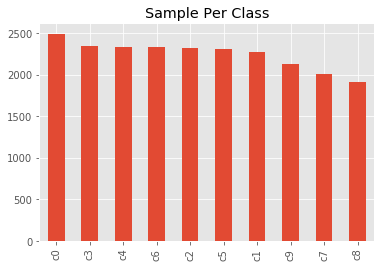

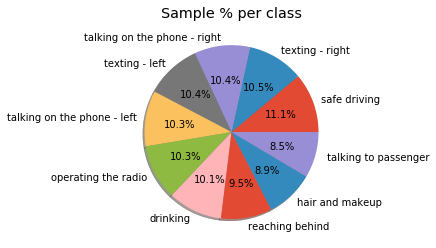

In [0]:
class_freq_count = df_train.classname.value_counts()

class_freq_count.plot(kind='bar', label='index')
plt.title('Sample Per Class');
plt.show()

plt.pie(class_freq_count, autopct='%1.1f%%', shadow=True, labels=CLASSES.values())
plt.title('Sample % per class');
plt.show()

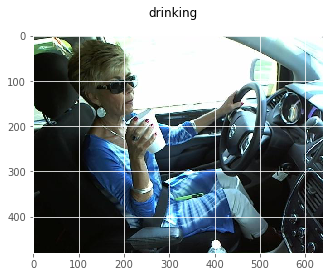

In [0]:
imgPath = os.path.join(kaggleDir, train_img_dir, "c6/img_20687.jpg")
img = load_img(imgPath)
plt.suptitle(CLASSES['c6'])
plt.imshow(img)

In [0]:
def draw_driver(imgs, df, classId='c0'):
    fig, axis = plt.subplots(2, 3, figsize=(20, 7))
    for idnx, (idx, row) in enumerate(imgs.iterrows()):
        imgPath = os.path.join(kaggleDir, train_img_dir, f"{classId}/{row['img']}")
        row = idnx // 3
        col = idnx % 3 
        img = load_img(imgPath)
        #         img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        plt.imshow(img)
        axis[row, col].imshow(img)
    plt.suptitle(CLASSES[classId])
    plt.show()


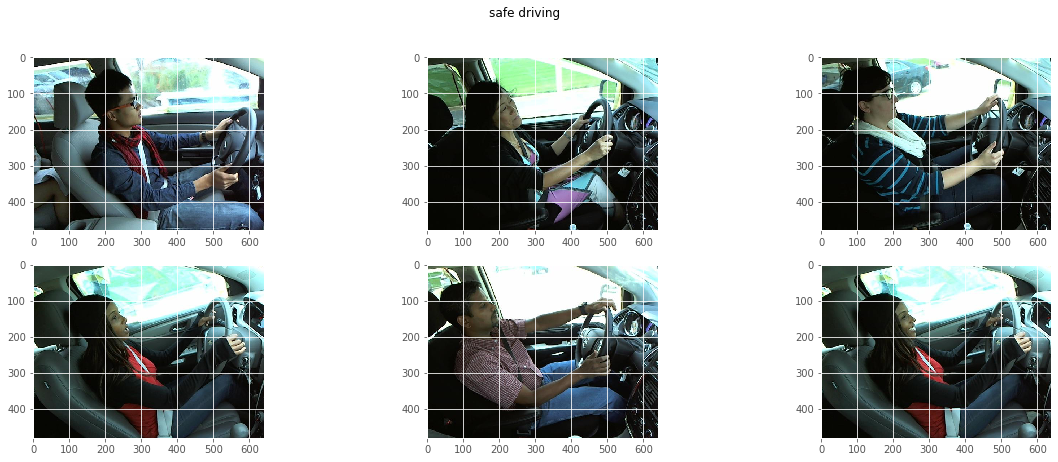

In [0]:
draw_driver(df_train[df_train.classname == 'c0'].head(6), df_train, classId='c0')

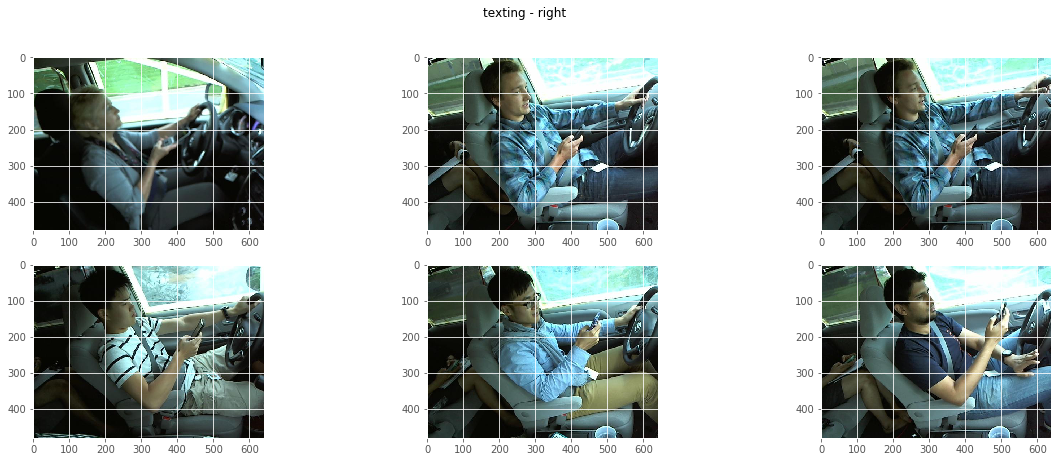

In [0]:
draw_driver(df_train[df_train.classname == 'c1'].head(6), df_train, classId='c1')

# Image Pre-Processing

In [0]:
dfY = df_train.classname
x_train, x_test, y_train, y_test = train_test_split(df_train, dfY, test_size=0.15, stratify=dfY)
print('Number of Samples in XTrain : {} Ytrain: {}'.format(x_train.shape[0], y_train.shape[0]))
print('Number of Samples in Xtest : {} Ytest: {}'.format(x_test.shape[0], y_test.shape[0]))

Number of Samples in XTrain : 19060 Ytrain: 19060
Number of Samples in Xtest : 3364 Ytest: 3364


In [0]:
df_train.head()

,subject,classname,img
15104,p050,c6,img_95325.jpg
13940,p049,c4,img_38128.jpg
3115,p015,c7,img_62528.jpg
599,p002,c7,img_39755.jpg
3875,p016,c5,img_69053.jpg


In [0]:
df_train['file_name']=df_train.img.apply(lambda  x:x[:-4])

In [0]:
df_train.head()

,subject,classname,img,file_name
15104,p050,c6,img_95325.jpg,img_95325
13940,p049,c4,img_38128.jpg,img_38128
3115,p015,c7,img_62528.jpg,img_62528
599,p002,c7,img_39755.jpg,img_39755
3875,p016,c5,img_69053.jpg,img_69053


In [0]:
class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        #         print("[INFO] : Simple PreProcessor invoked...!")
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        #         print("[INFO] : Prepossess Resizing invoked...!")
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

In [0]:
class ImageToArrayPreprocessor:
    def __init__(self, dataFormat=None):
        self.dataFormat = dataFormat

    def preprocess(self, image):
        return img_to_array(image, data_format=self.dataFormat)

In [0]:
class SimpleDataLoader:
    def __init__(self, preprocessors=None):
        self.preprocessors = preprocessors
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, trainImgs, verbose=-1):
        imgData = []
        imgLabels = []
        for (idx, imgPath) in enumerate(trainImgs):
            tmpImg = cv2.imread(imgPath)
            classLabel = imgPath.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for preprocesor in self.preprocessors:
                    img = preprocesor.preprocess(tmpImg)
                    gc.collect()
                imgData.append(tmpImg)
                imgLabels.append(imgLabels)

            if verbose > 0 and idx > 0 and (idx + 1) % verbose == 0:
                print('[INFO]: Processed {}/{}'.format((idx + 1), len(trainImgs)))
        print(len(imgData), len(imgLabels))
        return np.array(imgData), np.array(imgLabels)

In [0]:
print("[INFO] : Loading data from desk and scale the raw pixel intensities to the range [0,1] ....!")


[INFO] : Loading data from desk and scale the raw pixel intensities to the range [0,1] ....!


# Data Augmentation
Data Augmentation is the technique to generate new sample from the existing sample. So, you can reduce generalization error. It will genrerate natrual sample. There are number of features, which can help you in data agumentation.

rotation_range : is a value in degrees (0-180), a range within which to randomly rotate pictures.

height_shift_range : Constructor control the amount of horizontal and vertical shift respectively.

width_shift_range : Constructor control the amount of horizontal and vertical shift respectively.

shear_range : Shear Intensity (Shear angle in counter-clockwise direction in degrees)

zoom_range : Range for random zoom

horizontal_flip : Randomly filp of input image in horizontally. But we can't use in our case. It can chane the class of images.

fill_mode : Points outside the boundaries of the input image are filled according to the given mode. (default Nearest)

In [0]:
imgPath = os.path.join(kaggleDir, train_img_dir, "c6/img_20687.jpg")
image=load_img(imgPath)
image=img_to_array(image)
image=np.expand_dims(image, axis=0)
generator = ImageDataGenerator(rotation_range=30,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               shear_range=0.2,
                               zoom_range=0.2,
#                                horizontal_flip=True,
                               fill_mode='nearest') 
imageGen=generator.flow(image,batch_size=1)

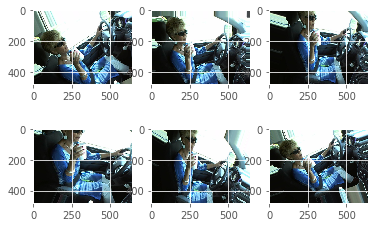

In [0]:


for i in range(6):
    nextImg=imageGen.next()
    plt.subplot(230 + 1 + i)
    image = nextImg[0].astype('uint8')
    plt.imshow(image)
plt.show()



In [0]:
generator = ImageDataGenerator(rescale=1 / 255.0,
                               zoom_range=30,
                               samplewise_center=True,
                               height_shift_range=0.2,
                               width_shift_range=0.2,
                               shear_range=0.2, 
                               fill_mode='nearest',
                               validation_split=0.15)

In [0]:


train_generator = generator.flow_from_directory(directory=os.path.join(kaggleDir, train_img_dir),
                                                classes=CLASSES.keys(),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                target_size=(IMG_DIM, IMG_DIM),
                                                shuffle=True,
                                                seed=SEED_VAL,
                                                subset='training')
valid_generator = generator.flow_from_directory(directory=os.path.join(kaggleDir, train_img_dir),
                                                classes=CLASSES.keys(),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                target_size=(IMG_DIM, IMG_DIM),
                                                shuffle=True,
                                                seed=SEED_VAL,
                                                subset='validation')
train_generator.class_indices
gc.collect()



Found 15305 images belonging to 10 classes.
Found 2695 images belonging to 10 classes.


25773

In [0]:
train_generator.class_indices,valid_generator.samples

({'c0': 0,
  'c1': 1,
  'c2': 2,
  'c3': 3,
  'c4': 4,
  'c5': 5,
  'c6': 6,
  'c7': 7,
  'c8': 8,
  'c9': 9},
 2695)

In [0]:
trainImgs[:5]

['/content/drive/Shared drives/Tensors/DL/drivers/train/c0/img_10997.jpg',
 '/content/drive/Shared drives/Tensors/DL/drivers/train/c0/img_72874.jpg',
 '/content/drive/Shared drives/Tensors/DL/drivers/train/c0/img_87355.jpg',
 '/content/drive/Shared drives/Tensors/DL/drivers/train/c0/img_5514.jpg',
 '/content/drive/Shared drives/Tensors/DL/drivers/train/c0/img_88072.jpg']

# Keras Callbacks Functions

In [0]:
earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=8, verbose=1, min_delta=0.0000001)
reduceRL = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.001, min_delta=0.0001, verbose=1,
                             min_lr=1e-6)
callbacks = [reduceRL]  # earlyStop

# Neural Network Architecture

In [0]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=[IMG_DIM, IMG_DIM, 1], activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

model.add(Conv2D(filters=512, kernel_size=(3, 3), activation=elu))
model.add(Activation(activation=elu))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation=elu))
# model.add(Activation(activation=elu))
# model.add(MaxPooling2D())
# model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dense(3000))
model.add(Activation(activation=elu))
model.add(Dropout(rate=0.25))
model.add(Dense(2000))
model.add(Activation(activation=elu))
model.add(Dropout(rate=0.25))
model.add(Dense(len(CLASSES)))
model.add(Activation(activation=softmax))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 297, 297, 32)      320       
_________________________________________________________________
activation_19 (Activation)   (None, 297, 297, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 148, 148, 32)      0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 148, 148, 32)      128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 146, 146, 32)      9248      
_________________________________________________________________
activation_20 (Activation)   (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 73, 73, 32)       

In [0]:
# opt = SGD()#lr=0.0001
from keras.optimizers import adam
opt=adam()
model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc'])

In [0]:
History = model.fit_generator(train_generator,
                              steps_per_epoch=train_generator.samples // BATCH_SIZE,
                              validation_data=valid_generator,
                              validation_steps=valid_generator.samples // BATCH_SIZE,
                              epochs=EPOCHS,
                              verbose=1).history  
                              #callbacks=callbacks

Epoch 1/20
306/306 [==============================] - 145s 474ms/step - loss: 2.5299 - acc: 0.1385 - val_loss: 2.1882 - val_acc: 0.1421
Epoch 2/20
306/306 [==============================] - 139s 453ms/step - loss: 2.1471 - acc: 0.1392 - val_loss: 2.2207 - val_acc: 0.1341
Epoch 3/20
306/306 [==============================] - 138s 449ms/step - loss: 2.1380 - acc: 0.1411 - val_loss: 2.1257 - val_acc: 0.1297
Epoch 4/20
306/306 [==============================] - 138s 450ms/step - loss: 2.1304 - acc: 0.1405 - val_loss: 2.1478 - val_acc: 0.1472
Epoch 5/20
306/306 [==============================] - 136s 446ms/step - loss: 2.1526 - acc: 0.1425 - val_loss: 2.1718 - val_acc: 0.1335
Epoch 6/20
306/306 [==============================] - 137s 447ms/step - loss: 2.1980 - acc: 0.1321 - val_loss: 2.1671 - val_acc: 0.1409
Epoch 7/20
306/306 [==============================] - 136s 446ms/step - loss: 2.1353 - acc: 0.1416 - val_loss: 2.1437 - val_acc: 0.1406
Epoch 8/20
306/306 [============================

In [0]:
eval_loss, eval_acc = model.evaluate_generator(valid_generator, steps=valid_generator.samples / BATCH_SIZE);
print('[INFO] : Evaluation Accuracy : {:.2f}%'.format(eval_acc * 100))
print('[INFO] : Evaluation Loss : {}'.format(eval_loss))

[INFO] : Evaluation Accuracy : 14.53%
[INFO] : Evaluation Loss : 2.157208361007549


# Training Accurcy / Loss


In [0]:
History.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

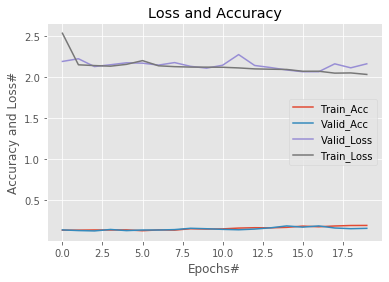

In [0]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, EPOCHS), History['acc'], label='Train_Acc')

plt.plot(np.arange(0, EPOCHS), History['val_acc'], label='Valid_Acc')
plt.plot(np.arange(0, EPOCHS), History['val_loss'], label='Valid_Loss')
plt.plot(np.arange(0, EPOCHS), History['loss'], label='Train_Loss')
plt.xlabel('Epochs#')
plt.ylabel('Accuracy and Loss#')
plt.title("Loss and Accuracy")
plt.legend()
plt.show()
